In [75]:
import datetime
today_date = datetime.datetime.now().strftime("%b-%d-%Y_%H-%M-%S")

In [1]:
#Imports
import numpy as np
import scipy.interpolate as spint
import pandas as pd

import astropy as ap
import astropy.io.fits as fits

import csky as cy
import histlite as hl
import healpy as hp
import matplotlib.pyplot as plt


In [80]:
plt.ioff()

In [95]:
#ARGS
import argparse
parser = argparse.ArgumentParser(description='Perform stacking analysis on 1FLE Blazars with the 10yrPStracks dataset.')
#data_save (def None)
parser.add_argument('--dat_form', default=None)
#gamma (float)
parser.add_argument('-g','--gamma', default=2.0)
#weighting_scheme ('flux' or 'equal')
parser.add_argument('-w', '--weight', default='equal')
#plot_flux_pdf (bool)
parser.add_argument('-f', '--flux_pdf', action='store_true')
#num_trials (int)
parser.add_argument('-n', '--trials', default=10000)
#seed
parser.add_argument('--seed', default=1)
#tol (default .01)
parser.add_argument('-t', '--tol', default=.01)
#n_batches (def 6)
parser.add_argument('--batches', default=6)
#batch_size (def 500)
parser.add_argument('--batch_size', default=500)
#n_sig_step (def 5)
parser.add_argument('--ns_step', default=5)
#first_batch_size (def 50)
parser.add_argument('--batch1', default=50)
#ref_E (def 100) -> 100 in units of below
parser.add_argument('--E0', default=100)
#flux_unit (def  1e3) -> TeV 
parser.add_argument('--funits', default=1e3)
#bg_trials_fname (def None)
parser.add_argument('--trfile', default=None)
#do_find_sens (bool)
parser.add_argument('-s', '--sens', action='store_true')
#do_find_disc (bool)
parser.add_argument('-d', '--disc', action='store_true')

In [2]:
#Open Catalog fits file
fits_1fle = fits.open('./1fle.fits')
#Get Column Names
cols = fits_1fle[1].data.columns.names
#Extract Blazars
b_mask = (fits_1fle[1].data['CLASS1'] == 'bll') | (fits_1fle[1].data['CLASS1'] == 'fsrq')
blaz_1fle = fits_1fle[1].data[b_mask]

#29 BL LACs -> seems like 2 were changed to FSRQ from paper
#102 FSRQs -> 2 from BL LAC and 2 from Unclassified from paper
#131 sources total

#Make into dictionary
data = {}
for n in cols:
    data[n] = blaz_1fle.field(n)
#Close Fits file
fits_1fle.close()

In [37]:
#Save source list with all data as CSV and Text Files
if data_save == 'csv':
    pd.DataFrame.from_dict(data).to_csv('/data/user/mcampana/analysis/Blazar_1FLE/1FLE_Blazars_Data.csv')
elif data_save == 'txt':
    f = open("/data/user/mcampana/analysis/Blazar_1FLE/1FLE_Blazars_Data.txt","w")
    f.write(str(data))
    f.close()
else:
    pass

NameError: name 'data_save' is not defined

In [13]:
#Weighting schemes
num_blaz = len(data['Name'])
#print(num_blaz)

#Equal weighting
eq_w = np.ones(num_blaz) / num_blaz

#Flux Weighting (integral energy flux 30-100MeV)
flux_w = np.copy(data['EF30-100'])

if weighting_scheme == 'equal':
    src_weights = eq_w
elif weighting_scheme == 'flux':
    src_weights = flux_w
else:
    raise NameError('Weighting scheme "{}" not accepted. Please use "equal" or "flux". '.format(weighting_scheme))

In [83]:
#Plot the Flux weight PDF
if plot_flux_pdf:
    plt.figure(figsize=(6,4))
    plt.hist(flux_w, bins='auto', histtype='step', linewidth=2)
    plt.xlabel("Energy Flux from 30-100 MeV [erg /cm^2 /s]")
    plt.ylabel("Weight [Counts]")
    plt.title("Energy Flux PDF for 1FLE Blazars")
    plt.savefig('/data/user/mcampana/analysis/Blazar_1FLE/plots/EnergyFlux_30-100MeV_PDF_seed{}_{}.png'.format(seed, today_date))
    plt.close()
    

In [20]:
#Data selection
selection = cy.selections.PSDataSpecs.ps_10yr

In [21]:
#Create analysis with data selection (saved in working dir)

#ana = cy.get_analysis(cy.selections.repo, selection)
#ana.save('./')

#ana = cy.get_analysis(cy.selections.repo, selection, dir='/data/user/mcampana/analysis/Blazar_1FLE')

#2011 only; for testing
ana = cy.get_analysis(cy.selections.repo, cy.selections.PSDataSpecs.ps_2011, dir='/data/user/mcampana/analysis/Blazar_1FLE')

Setting up Analysis for:
IC86_2011
Setting up IC86_2011...
Reading /data/ana/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2011_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2011_exp.npy ...
<- /data/user/mcampana/analysis/Blazar_1FLE/IC86_2011.subanalysis.npy    
Done.


In [18]:
#Provide source locations
srcs = cy.utils.Sources(ra=data['RAdeg'], dec=data['DEdeg'], deg=True, weight=src_weights)

In [22]:
#Get Trials RUnner
tr = cy.get_trial_runner(src=srcs, ana=ana, flux=cy.hyp.PowerLawFlux(gamma))

IC86_2011                                100%.     


In [23]:
#Do BG Trials
if do_bg_trials:
    trials = tr.get_many_fits(num_trials, seed=seed)
    #Save Trials to numpy array file
    save_trials_fname = '/data/user/mcampana/analysis/Blazar_1FLE/trials/BG_{}trials_{}weight_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.npy'.format(num_trials, weighting_scheme, gamma, seed, today_date)
    np.save(save_trials_fname, trials.as_array)
    print("Trials saved ->", save_trials_fname)
    
    #Get and save BG Chi2 info
    bg_chi2 = cy.dists.Chi2TSD(trials)
    save_bgchi2_fname = "/data/user/mcampana/analysis/Blazar_1FLE/trials/DescBG_{}trials_{}weight_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.txt".format(num_trials, weighting_scheme, gamma, seed, today_date)
    f = open(save_bgchi2_fname,"w")
    f.write(bg_chi2.description)
    f.close()
    print("Background Chi2 info saved ->", save_bgchi2_fname)
elif bg_trials_fname != None:
    trials = np.load(bg_trials_fname)
    trials = cy.utils.Arrays(trials)
    bg_chi2 = cy.dists.Chi2TSD(trials)
    print('Loaded trials from <-', bg_trials_fname)
else:
    raise ValueError('No trials run or given!')

Performing 200 background trials using 5 cores:
        200/200 trials complete.   


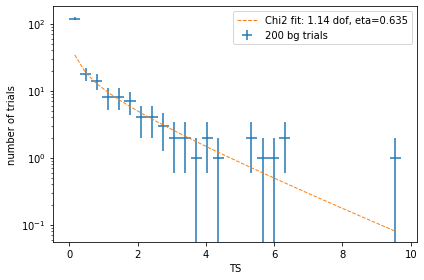

In [14]:
#Plot TS and chi2 distribution
if plot_TSchi2:
    fig, ax = plt.subplots()

    h = bg_chi2.get_hist(bins=30)
    hl.plot1d(ax, h, crosses=True, label='{} bg trials'.format(bg_chi2.n_total))

    x = h.centers[0]
    norm = h.integrate().values
    ax.semilogy(x, norm * bg_chi2.pdf(x), lw=1, ls='--',
                label='Chi2 fit: {} dof, eta={}'.format(np.round(bg_chi2.ndof,2), bg_chi2.eta))

    ax.set_xlabel('TS')
    ax.set_ylabel('number of trials')
    ax.legend()
    plt.tight_layout()
    plt.savefig('/data/user/mcampana/analysis/Blazar_1FLE/plots/Chi2TS_{}trials_{}weighting_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.png'.format(num_trials, weighting_scheme, gamma, seed, today_date))
    plt.close()

In [32]:
#Sensitivity
if do_find_sens:
    sens = tr.find_n_sig(
            bg_chi2.median(), 0.9,
            n_sig_step=n_sig_step,
            first_batch_size=first_batch_size,
            batch_size=batch_size,
            # 10% tolerance -- let's get an estimate quick!
            tol=tol,
            n_batches=n_batches,
            seed=seed
        )

    flux_sens = tr.to_E2dNdE(sens, E0=ref_E, unit=flux_unit)   # TeV/cm2/s  @  100TeV

    sens['info']['flux_sens'] = flux_sens
    sens['info']['inj_gamma'] = gamma
    sens['info']['flux_E0'] = ref_E
    sens['info']['flux_Eunit'] = flux_unit

    save_sens_fname = '/data/user/mcampana/analysis/Blazar_1FLE/sens_disc/SensInfo_{}trials_{}weighting_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.csv'.format(num_trials, weighting_scheme, gamma, seed, today_date)
    pd.DataFrame.from_dict(sens['info']).to_csv(save_sens_fname)
    print("Sensitivity info saved ->", save_sens_fname)

Start time: 2020-09-30 11:47:11.657610
Using 5 cores.
* Starting initial scan for 90% of 20 trials with TS >= 0.089...
  n_sig = 10.000 ... frac = 0.90000
* Generating batches of 200 trials...
n_trials | n_inj    0.00    4.00    8.00   12.00   16.00   20.00  |  n_sig(relative error)
200      |         48.5%   75.5%   87.5%   95.5%   95.5%   98.5%  |      8.963 (+/-  9.5%) [spline]
End time: 2020-09-30 11:49:51.684334
Elapsed time: 0:02:40.026724


In [16]:
#Discovery Potential

if do_find_sens:
    disc = tr.find_n_sig(
            bg_chi2.isf_nsigma(5), 0.5, 
            n_sig_step=n_sig_step,
            first_batch_size=first_batch_size,
            batch_size=batch_size, 
            tol=tol,
            n_batches=n_batches,
            seed=seed
        )

    flux_disc = tr.to_E2dNdE(disc, E0=ref_E, unit=flux_unit)   # TeV/cm2/s  @  100TeV

    disc['info']['flux_sens'] = flux_sens
    disc['info']['inj_gamma'] = gamma
    disc['info']['flux_E0'] = ref_E
    disc['info']['flux_Eunit'] = flux_unit

    save_disc_fname = '/data/user/mcampana/analysis/Blazar_1FLE/sens_disc/DiscInfo_{}trials_{}weighting_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.csv'.format(num_trials, weighting_scheme, gamma, seed, today_date)
    pd.DataFrame.from_dict(disc['info']).to_csv(save_disc_fname)
    print("Discovery potential info saved ->", save_disc_fname)

Start time: 2020-09-28 17:17:28.684954
Using 5 cores.
* Starting initial scan for 50% of 20 trials with TS >= 28.420...
  n_sig = 10.000 ... frac = 0.00000
  n_sig = 20.000 ... frac = 0.20000
  n_sig = 30.000 ... frac = 0.35000
  n_sig = 40.000 ... frac = 0.75000
* Generating batches of 200 trials...
n_trials | n_inj    0.00   16.00   32.00   48.00   64.00   80.00  |  n_sig(relative error)
200      |          0.0%    3.0%   51.5%   86.5%   99.5%  100.0%  |     31.437 (+/-  3.6%) [spline]
End time: 2020-09-28 17:21:57.770703
Elapsed time: 0:04:29.085749


In [20]:
#Doing Bias tests:
if do_bias_test:
    n_sigs = np.r_[:101:10]
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))

    allt = cy.utils.Arrays.concatenate(trials)

    fig, axs = plt.subplots(1, 2, figsize=(6,3))

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')


    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel('n_inj')
        ax.grid()
    axs[0].set_ylabel('n_s')
    axs[1].set_ylabel('gamma')

    plt.tight_layout()
    plt.savefig('/data/user/mcampana/analysis/Blazar_1FLE/plots/BiasTest_{}weighting_gamma{}_10yrPStracks_1FLEblazars_seed{}_{}.png'.format(weighting_scheme, gamma, seed, today_date))
    plt.close()

In [ ]:
print('===========================')
print('===== Script Finished =====')